### Context
- This analysis focuses on predicting credit card fraud using an anonymized dataset. The goal is to develop models that can effectively identify fraudulent transactions while minimizing false negatives.
- As the data is anonymized, features are labeled V1 to V28, and the "Class" column indicates whether a transaction is fraudulent (1) or not (0).
- Given the critical nature of fraud detection, the emphasis is on maximizing recall to capture as many fraudulent cases as possible, even if it leads to some false positives.
- The machine learning pipeline includes data exploration, scaling, and the training and evaluation of multiple models, including logistic regression, naive Bayes, and XGBoost.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import randint

### 1. Loading and Checking Data:

- Load the dataset from a CSV file named "data.csv" into a Pandas DataFrame (`df`).
- An assertion checks if there are no missing values in the DataFrame.

In [2]:
df = pd.read_csv("data.csv")

assert df.isna().sum().sum() == 0, "df contains missing values"

### 2. Displaying Dataset Information:

- Display the first 3 rows and transpose the DataFrame to observe its structure.
- Display descriptive statistics for each column in the DataFrame.

In [3]:
df.head(3).T

,0,1,2
Time,0.000000,0.000000,1.000000
V1,-1.359807,1.191857,-1.358354
V2,-0.072781,0.266151,-1.340163
V3,2.536347,0.166480,1.773209
V4,1.378155,0.448154,0.379780
V5,-0.338321,0.060018,-0.503198
V6,0.462388,-0.082361,1.800499
V7,0.239599,-0.078803,0.791461
V8,0.098698,0.085102,0.247676
V9,0.363787,-0.255425,-1.514654


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [5]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
def confusion_matrix_metrics(conf_matrix: np.ndarray) -> dict:
    """
    Calculate and display metrics based on a 2x2 confusion matrix.

    Args:
        conf_matrix (np.ndarray): A 2x2 confusion matrix.

    Returns:
        dict: A dictionary containing the following metrics:
            - TP (True Positive)
            - TN (True Negative)
            - FP (False Positive)
            - FN (False Negative)
            - Accuracy
            - Precision
            - Recall
            - F1 Score
    """
    assert conf_matrix.shape == (2, 2), "Confusion matrix must be a 2x2 matrix"

    tn, fp, fn, tp = conf_matrix.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return {
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Accuracy ": f"{accuracy * 100:.2f}%",
        "Precision": f"{precision * 100:.2f}%",
        "Recall   ": f"{recall * 100:.2f}%",
        "F1 Score ": f"{f1_score * 100:.2f}%",
    }

### 3. Data Exploration - Violin Plot:

- Create a violin plot to visualize the distribution of variables (excluding "Class," "Time," and "Amount").

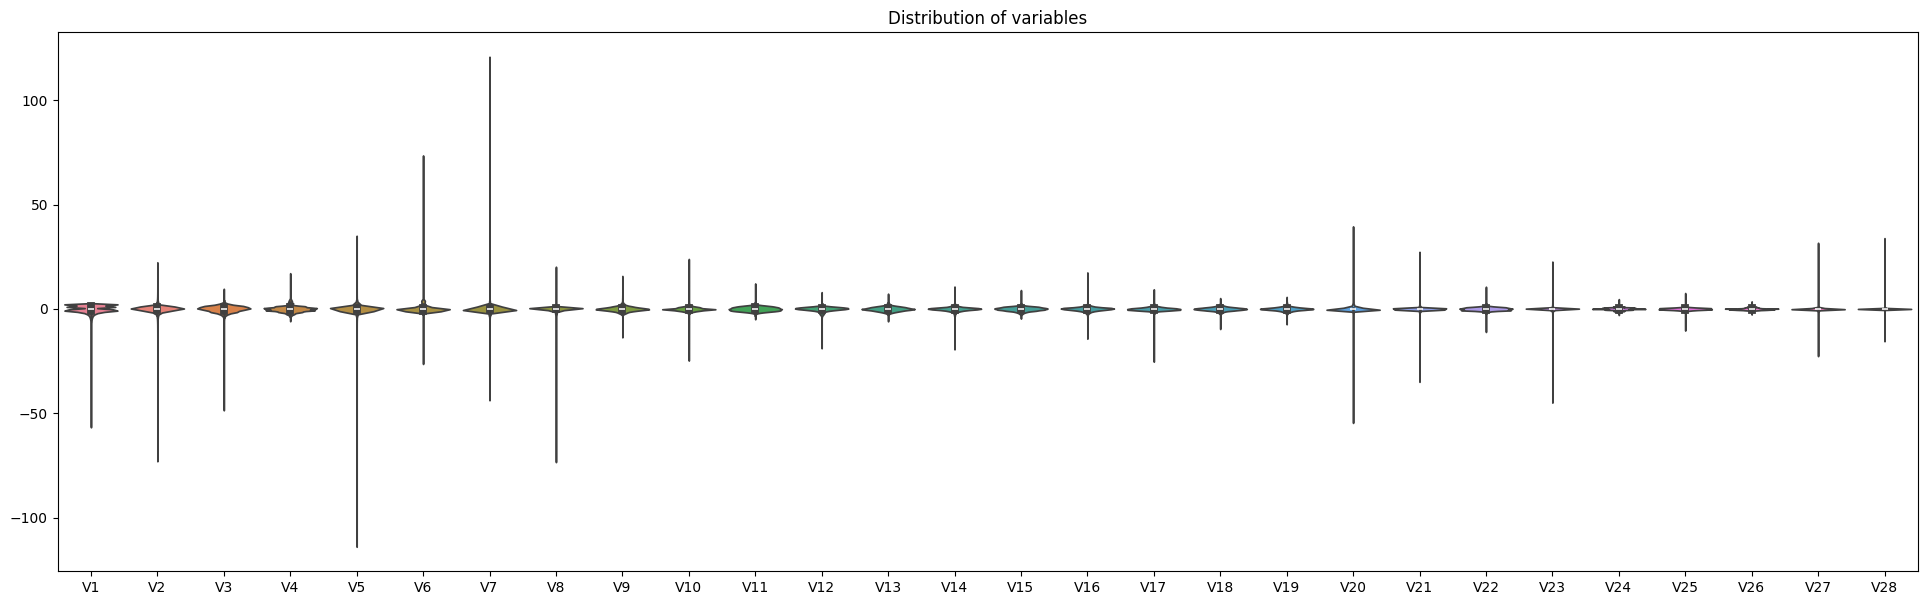

In [7]:
plt.figure(figsize=(24, 7))
sns.violinplot(data=df.drop(columns=["Class", "Time", "Amount"]))
plt.title("Distribution of variables")
plt.show()

### 4. Data Scaling:

- Scale the feature variables using StandardScaler.
- Split the data into training and testing sets.

In [8]:
scaler = StandardScaler()

X = df.drop(columns=["Class"])
y = df["Class"]

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.75, random_state=123
)

- Seems like most of the columns are normally distributed

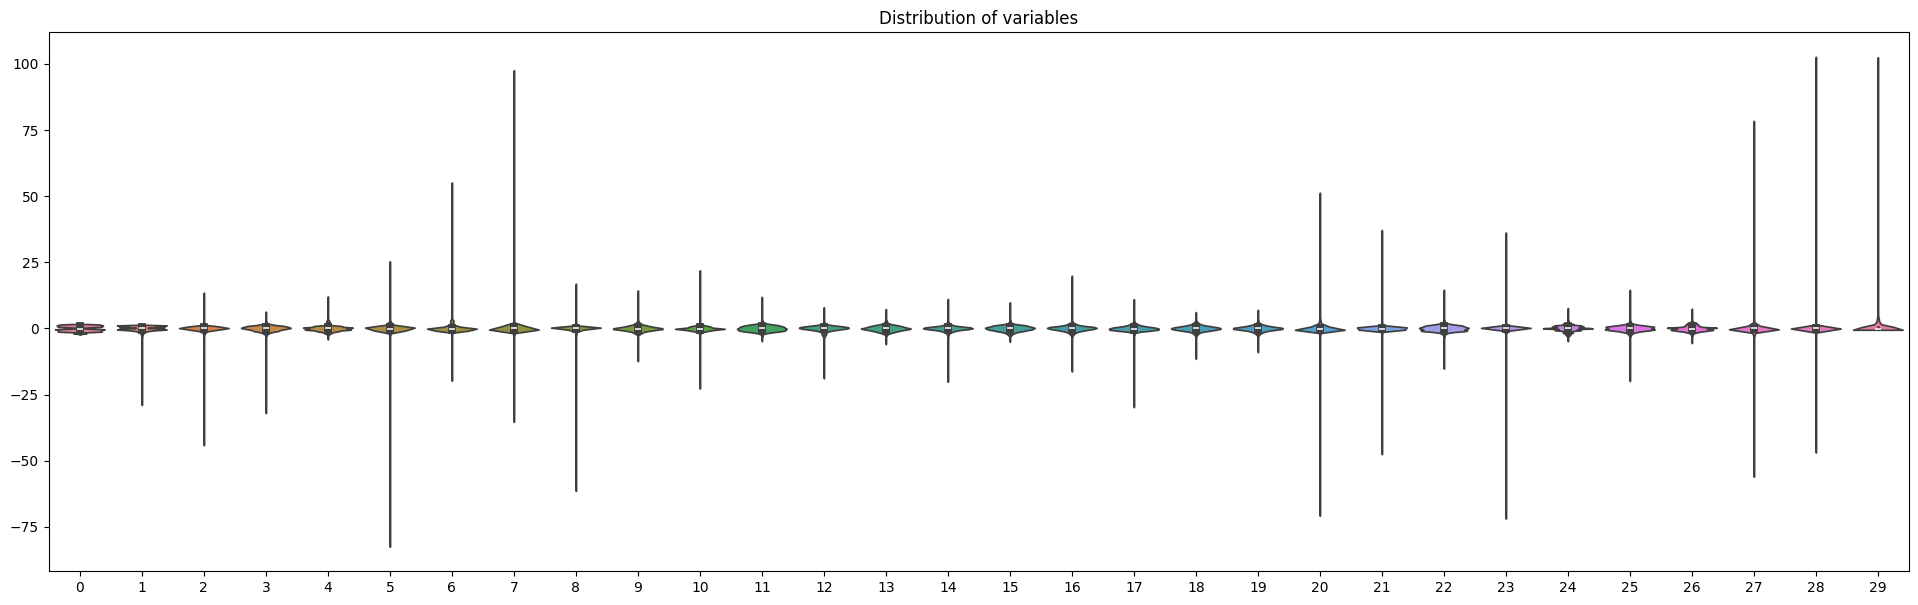

In [9]:
plt.figure(figsize=(24, 7))
sns.violinplot(data=X_scaled)
plt.title("Distribution of variables")
plt.show()

### 5. Logistic Regression Model:

- Train a logistic regression model on the scaled training data.
- Set a threshold for probability predictions

In [10]:
lr_model = LogisticRegression(max_iter=100_000)

lr_model.fit(X_train, y_train)
predicted_probabilities = lr_model.predict_proba(X_test)[:, 1]

threshold = 0.19

lr_y_pred = (predicted_probabilities >= threshold).astype(int)

lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)

confusion_matrix_metrics(lr_conf_matrix)

{'TP': 283,
 'TN': 213150,
 'FP': 74,
 'FN': 99,
 'Accuracy ': '99.92%',
 'Precision': '79.27%',
 'Recall   ': '74.08%',
 'F1 Score ': '76.59%'}

### 6. Bernoulli Naive Bayes Model:

- Train a Bernoulli Naive Bayes model on the scaled training data.


In [11]:
nb_model = BernoulliNB()

nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)

nb_conf_matrix = confusion_matrix(nb_y_pred, y_test)
confusion_matrix_metrics(nb_conf_matrix)

{'TP': 248,
 'TN': 213171,
 'FP': 134,
 'FN': 53,
 'Accuracy ': '99.91%',
 'Precision': '64.92%',
 'Recall   ': '82.39%',
 'F1 Score ': '72.62%'}

### 7. XGBoost Model with Hyperparameter Tuning:

- Train an XGBoost classifier with hyperparameter tuning using RandomizedSearchCV.

In [12]:
xgb = XGBClassifier()

xgb_param_dist = {
    "n_estimators": randint(10, 200),
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "max_depth": randint(1, 20),
    "min_child_weight": randint(1, 10),
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_alpha": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_lambda": [0, 0.1, 0.2, 0.3, 0.4],
}

xgb_random_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    random_state=123,
)

xgb_random_search.fit(X_train, y_train)
best_xgb_params = xgb_random_search.best_params_

xgb_model = xgb_random_search.best_estimator_

xgb_y_pred = xgb_model.predict(X_test)

xgb_conf_matrix = confusion_matrix(xgb_y_pred, y_test)
confusion_matrix_metrics(xgb_conf_matrix)

{'TP': 302,
 'TN': 213200,
 'FP': 80,
 'FN': 24,
 'Accuracy ': '99.95%',
 'Precision': '79.06%',
 'Recall   ': '92.64%',
 'F1 Score ': '85.31%'}

### 8. Stacking Classifier:

- Define a list of base estimators (Logistic Regression, Naive Bayes, and XGBoost).
- Create a StackingClassifier with XGBoost as the final estimator.

In [13]:
estimators = [
    ("xgb", xgb_model),
    ("linear", lr_model),
    ("naive_bayes", nb_model),
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(**best_xgb_params),
    stack_method="auto",
    cv=5,
    n_jobs=-1,
    passthrough=True,
)

stacking_model.fit(X_train, y_train)

stacking_y_pred = stacking_model.predict(X_test)

stacking_conf_matrix = confusion_matrix(stacking_y_pred, y_test)
confusion_matrix_metrics(stacking_conf_matrix)

{'TP': 308,
 'TN': 213200,
 'FP': 74,
 'FN': 24,
 'Accuracy ': '99.95%',
 'Precision': '80.63%',
 'Recall   ': '92.77%',
 'F1 Score ': '86.27%'}


- Precision, measuring the accuracy of positive predictions, is at a respectable 80.63%, suggesting a low rate of false positives.
- The recall, a critical metric for fraud detection, stands at an impressive 92.77%. This indicates the model's capability to capture a significant portion of actual fraudulent transactions.
- The F1 Score, considering both precision and recall, is commendable at 86.27%, demonstrating a balanced trade-off between precision and recall.